In [3]:
# Import necessary libraries
import os
import zipfile
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt


In [4]:
# Read the CSV file with building metadata
metadata_df = pd.read_csv('building_polygons_metadata.csv')

# Display the first few rows to understand the structure
metadata_df.head()

# Filter for post-disaster images only
post_disaster_df = metadata_df[metadata_df['stage'] == 'post']

# Define disaster label mapping
disaster_labels = {
    'volcano': 1,
    'fire': 2,
    'tsunami': 3,
    'flooding': 4,
    'earthquake': 5,
    'wind': 6
}

post_disaster_df = (
    metadata_df.query("stage == 'post'")
    .assign(disaster_label=lambda x: x['disaster'].map(disaster_labels))
)

# Count images by disaster type
disaster_counts = post_disaster_df['disaster'].value_counts()
print("Post-disaster image counts by type:")
print(disaster_counts)


Post-disaster image counts by type:
disaster
flooding      38216
wind          36625
earthquake    32271
tsunami       31394
fire          23425
volcano         856
Name: count, dtype: int64


In [5]:
import os

# Directory where all images are stored
image_dir = 'cropped_square_buildings'

def find_image_path(row):
    # Construct the expected filename
    filename = f"{row['uid']}_{row['stage']}.png"
    path = os.path.join(image_dir, filename)
    return path if os.path.isfile(path) else None

# Generate image paths for all rows
post_disaster_df['image_path'] = post_disaster_df.apply(find_image_path, axis=1)

# Keep only rows where the image file exists
valid_data_df = post_disaster_df[post_disaster_df['image_path'].notnull()]

print(f"Total post-disaster records: {len(post_disaster_df)}")
print(f"Valid post-disaster images found: {len(valid_data_df)}")

# Optional: Show a few missing images for debugging
if len(valid_data_df) < len(post_disaster_df):
    print("Examples of missing images:")
    missing = post_disaster_df[post_disaster_df['image_path'].isnull()].head()
    for idx, row in missing.iterrows():
        print(f"Missing: {row['uid']}_{row['stage']}.png")


Total post-disaster records: 162787
Valid post-disaster images found: 117485
Examples of missing images:
Missing: 425ae212-6733-4f5c-8382-997bec5d1497_post.png
Missing: f6762c00-8ebb-4c8d-a732-9b1c57581a33_post.png
Missing: aac05a0a-03e8-4f71-a1f3-f109abf2e88a_post.png
Missing: c659f61c-3abc-4df2-9ceb-9df69cbd5fa8_post.png
Missing: 7672395f-90c8-4a47-a46b-d48d001d03ec_post.png


Train set size: 82239
Validation set size: 17623
Test set size: 17623


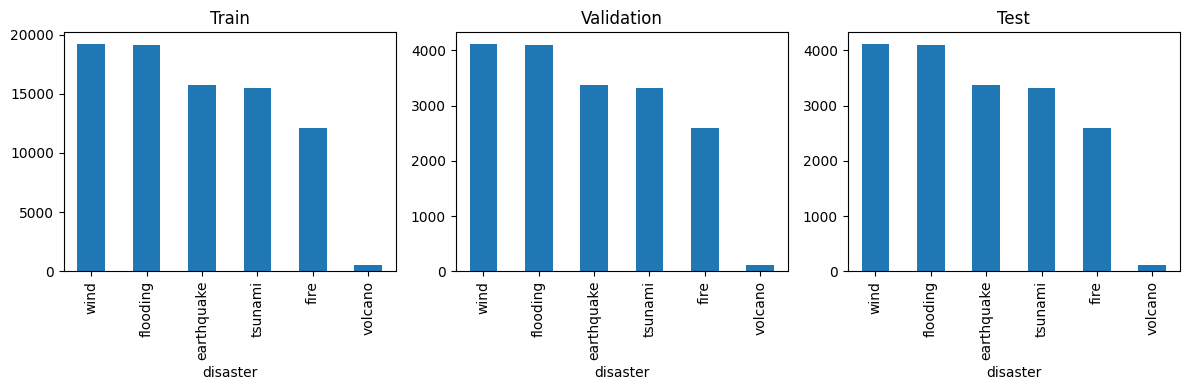

In [6]:
# Create data splits (70% train, 15% validation, 15% test)
train_df, temp_df = train_test_split(
    valid_data_df, 
    test_size=0.3, 
    random_state=42, 
    stratify=valid_data_df['disaster_label']
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['disaster_label']
)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Visualize distribution of disaster types in each split
plt.figure(figsize=(12, 4))
train_df['disaster'].value_counts().plot(kind='bar', ax=plt.subplot(131), title='Train')
val_df['disaster'].value_counts().plot(kind='bar', ax=plt.subplot(132), title='Validation')
test_df['disaster'].value_counts().plot(kind='bar', ax=plt.subplot(133), title='Test')
plt.tight_layout()
plt.show()


In [7]:
# Custom dataset class for disaster images
class DisasterImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['disaster_label'] - 1  # Convert to 0-indexed
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = DisasterImageDataset(train_df, transform=train_transform)
val_dataset = DisasterImageDataset(val_df, transform=val_test_transform)
test_dataset = DisasterImageDataset(test_df, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [8]:
# Load pre-trained ResNet-18 model
try:
    # For newer PyTorch versions
    model = models.resnet18(weights='IMAGENET1K_V1')
except:
    # For older PyTorch versions
    model = models.resnet18(pretrained=True)

# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final classification layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)  # 6 disaster types

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=0.0001)


Using device: cuda


In [11]:
import os
from tqdm.auto import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, save_path='best_disaster_model.pth'):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Ensure save_path is writable
    save_path = os.path.expanduser(save_path)
    save_dir = os.path.dirname(save_path)
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    # Outer epoch progress bar (leave=True keeps it on screen)
    epoch_pbar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch", leave=True)

    for epoch in epoch_pbar:
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Inner batch progress bar (leave=False so it disappears after each epoch)
        batch_pbar = tqdm(train_loader, 
                         desc=f'Epoch {epoch+1}/{num_epochs} [Training]',
                         leave=False,
                         unit="batch")
        for inputs, labels in batch_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            batch_pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{torch.sum(preds == labels.data).item()/inputs.size(0):.2%}"
            })

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())

        # Update the outer epoch bar with current stats
        epoch_pbar.set_postfix({
            'train_loss': f"{epoch_loss:.4f}",
            'train_acc': f"{epoch_acc:.2%}",
            'val_loss': f"{val_epoch_loss:.4f}",
            'val_acc': f"{val_epoch_acc:.2%}"
        })

        # Save best model with try/except
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            try:
                torch.save(model.state_dict(), save_path)
                tqdm.write(f"Model saved to {save_path} at epoch {epoch+1}")
            except Exception as e:
                tqdm.write(f"Warning: Could not save model at epoch {epoch+1}: {e}")

    tqdm.write("Training complete.")
    return model, history


In [12]:

# Train the model
num_epochs = 15
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


Training Progress:   0%|          | 0/15 [00:00<?, ?epoch/s]

Epoch 1/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Model saved to best_disaster_model.pth at epoch 1


Epoch 2/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Model saved to best_disaster_model.pth at epoch 2


Epoch 3/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Model saved to best_disaster_model.pth at epoch 3


Epoch 4/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Model saved to best_disaster_model.pth at epoch 4


Epoch 5/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Model saved to best_disaster_model.pth at epoch 5


Epoch 6/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Model saved to best_disaster_model.pth at epoch 6


Epoch 7/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Epoch 8/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Model saved to best_disaster_model.pth at epoch 8


Epoch 9/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1512769f94e0>
Traceback (most recent call last):
Exception ignored in:   File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x1512769f94e0>    self._shutdown_workers()

Traceback (most recent call last):
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        if w.is_alive():
self._shutdown_workers()
   File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
      if w.is_alive():
         ^ ^ ^^^^^^^^^^^^^^^^^^^^^^

  File "/ext3/miniforge3/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/ext3/miniforge3/lib/python3.12/multiprocessing/process

Model saved to best_disaster_model.pth at epoch 9


Epoch 10/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1512769f94e0>
Traceback (most recent call last):
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1512769f94e0> 
Traceback (most recent call last):
    File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers() 
   File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
^    if w.is_alive():^
^ ^ ^   ^^ ^ ^^^^^^
^^^^  File "/ext3/miniforge3/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child pro

Epoch 11/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1512769f94e0>
Traceback (most recent call last):
Exception ignored in:   File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x1512769f94e0>
    Traceback (most recent call last):
self._shutdown_workers()
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/ext3/miniforge3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers

          if w.is_alive():
  ^  ^  ^^^^^^^^  ^^^^^
  File "/ext3/miniforge3/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^^assert self._parent_pid == os.getpid(), 'can only test a child pr

Model saved to best_disaster_model.pth at epoch 11


Epoch 12/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Model saved to best_disaster_model.pth at epoch 12


Epoch 13/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Epoch 14/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Epoch 15/15 [Training]:   0%|          | 0/2570 [00:00<?, ?batch/s]

Training complete.


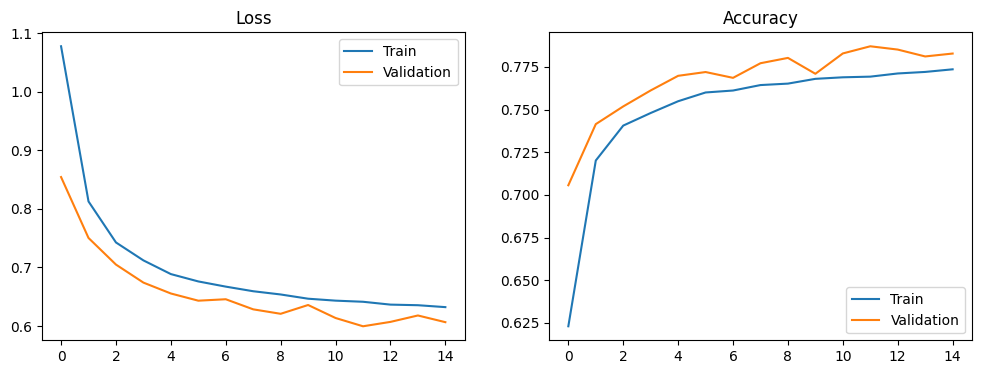

In [14]:
from tqdm.auto import tqdm

# Plot training history (no progress bar needed here, it's fast)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.show()


Evaluating on test set:   0%|          | 0/551 [00:00<?, ?batch/s]

Test Accuracy: 0.7870


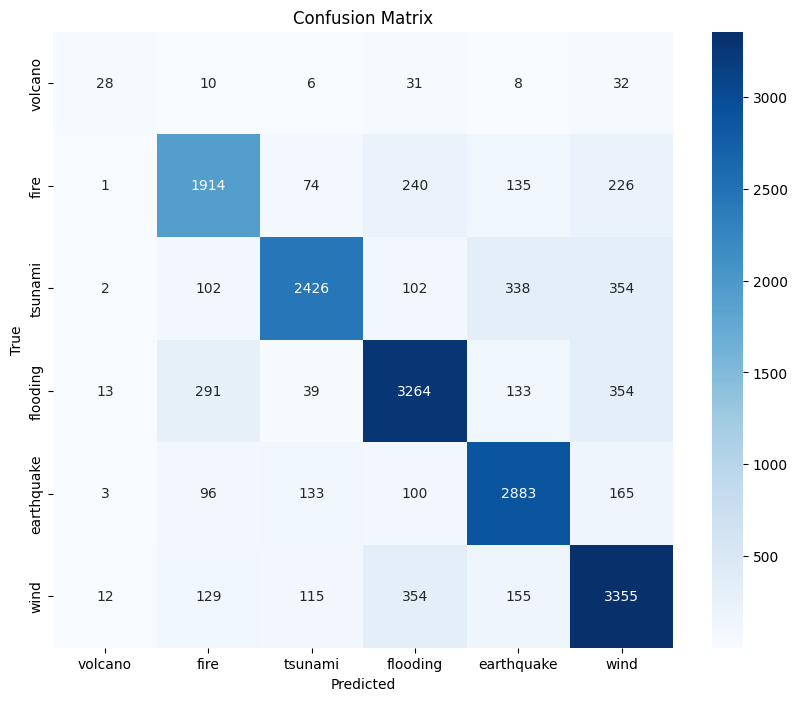

In [15]:

# Load the best model
model.load_state_dict(torch.load('best_disaster_model.pth'))

# Evaluate on test set with progress bar
def evaluate_model(model, test_loader):
    model.eval()
    test_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        # Add tqdm progress bar here
        for inputs, labels in tqdm(test_loader, desc="Evaluating on test set", unit="batch"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            test_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_acc = test_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {test_acc:.4f}')
    
    return test_acc, all_preds, all_labels

# Run evaluation
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)

# Plot confusion matrix (no progress bar needed here)
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = list(disaster_labels.keys())
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
